# Setup

In [235]:

from pathlib import Path
import json
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Create synapses table as DataFrame from csv

## synapses table 

In [69]:
# dirpath = Path('<path to folder with file>')
dirpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/graphs')
df_syn = pd.read_csv(dirpath / 'df_pfsyn.csv') #df_pfsyn #df_presyn_filt #df_postsyn_mg


## cell types table

In [70]:
# dirpath = Path('<path to folder with file>')
dirpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/metadata')
df_type = pd.read_csv(dirpath / 'df_type.csv')


## add cell type column to df_syn

In [71]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

# Patterns of connectivity (PCA)

In [38]:
def calculate_percent_total(row):
    # normalizes each pre cell to fraction total synapses per post cell type rather than number of synapses per post cell type
    total = row.sum()
    if total == 0:
        return row  # If total is 0, return the row as is (unchanged)
    else:
        return row / total  # Normalize by dividing each element by the total
#row / total 

## Use PCA module from scikit-learn decomposition

In [72]:
# change as needed based on which synapses table you import and which cell types you want to include

# post-synaptic labeling
dsource = 'pre_type'
idsource = 'pre'
dtarget = 'post_type'
idtarget = 'post'

# # pre-synaptic labeling
# dsource = 'post_type'
# idsource = 'post'
# dtarget = 'pre_type'
# idtarget = 'pre'

# Desired source_types and order
source_types_order = ['pf'] #['mg1','lg', 'mg2','lf'] #['mg1','mg2'] #
# Desired target_types and order
target_types_order = ['sg1', 'mg1','lg', 'sg2','mg2','lf']  #['aff','smpl','sg1','grc','sg2'] #['mg1','lg', 'mg2','lf'] #

### data

In [50]:
mask = df_syn[dsource].isin(source_types_order) & df_syn[dtarget].isin(target_types_order)  # Filter out rows with post_type not in post_groups and pre_type not in pre_groups
df_syn_data = df_syn[mask]

# get total synaptic weight between each pre-post cell pair
df_edges_data=df_syn_data[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

# Pivot table to get sum of weights per post and pre_type
pivot_df = df_edges_data.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)

# Reindex columns to include only the specified pre_types in the desired order
pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)

# Reset index to turn 'post' and 'post_type' from index to columns
pivot_df.reset_index(inplace=True)

# Sort the dataframe based on post_type
pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
pivot_df.sort_values(dsource, inplace=True)
pivot_df.set_index(idsource, inplace=True)

# Apply the fraction total synapses normalization function to each row (each pre cell)
norm_df = pivot_df.select_dtypes(include='number').apply(calculate_percent_total, axis=1)

# Standardize the data for each feature
scaler = StandardScaler()
scaled_data = scaler.fit_transform(norm_df)

# Perform PCA
npc = len(target_types_order)
pca_ = PCA(n_components=npc)  

pca_result = pca_.fit_transform(scaled_data)

# get loadings of dimensions onto each principal component
loadings = pca_.components_.T

# Add PCA results to the DataFrame
for i in range(npc):
    pivot_df[str(i)] = pca_result[:, i]

result_data = pd.DataFrame(pca_.explained_variance_ratio_.reshape(1, -1),columns=range(len(pca_.explained_variance_ratio_)))

In [51]:
pivot_df.head()

pre_type,post_type,aff,smpl,sg1,grc,sg2,0,1,2,3,4
post,,,,,,,,,,,
386224676,mg1,0,0,0,37,30,-1.892689,0.090936,-0.126069,0.044754,3.701052e-16
299392199,mg1,0,4,0,25,39,-1.581464,-0.060571,0.635734,-0.403555,2.883299e-16
299405462,mg1,0,6,0,60,14,-1.441995,-0.333397,-1.339316,-0.278613,3.642431e-16
299439953,mg1,0,0,0,31,48,-1.912573,0.176242,0.680099,-0.046850,7.639015e-17
299496636,mg1,0,0,0,111,106,-1.897755,0.112668,0.079305,0.021418,-1.197765e-16


<AxesSubplot:xlabel='0', ylabel='1'>

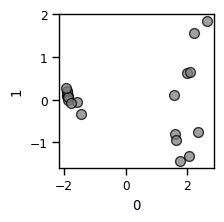

In [52]:
# plot first and second PC against each other

hfig,ax = plt.subplots(1,figsize=(2,2))
sns.scatterplot(ax=ax,data=pivot_df,x='0',y='1',linewidth=1,color='gray',edgecolor='black',s=50,alpha = 0.75)

# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

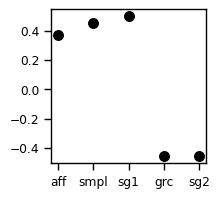

In [53]:
# plot loadings of features onto first principle component

hfig,ax = plt.subplots(figsize = (2,2))
ax.scatter(target_types_order,[l[0] for l in loadings],color = 'black',s=50)

### shuffle 

In [54]:
mask = df_syn[dsource].isin(source_types_order) & df_syn[dtarget].isin(target_types_order)  # Filter out rows with post_type not in post_groups and pre_type not in 

result_shuff = pd.DataFrame()
# Iterate the specified number of times
for i in range(50):
    # Shuffle the dataframe
    df_syn_rand = deepcopy(df_syn[mask])

    # for presynaptic datasets
    shuff_rows = df_syn_rand[['post','post_type']].sample(frac = 1)
    df_syn_rand.loc[:,['post']] = shuff_rows['post'].values
    df_syn_rand.loc[:,['post_type']] = shuff_rows['post_type'].values

    # for postsynaptic datasets
    shuff_rows = df_syn_rand[['pre','pre_type']].sample(frac = 1)
    df_syn_rand.loc[:,['pre']] = shuff_rows['pre'].values
    df_syn_rand.loc[:,['pre_type']] = shuff_rows['pre_type'].values
    
    df_edges_shuff=df_syn_rand[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')
    
    # Pivot table to get sum of weights per post and pre_type
    pivot_df = df_edges_shuff.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)
    
    # Reindex columns to include only the specified pre_types in the desired order
    pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)
    
    # Reset index to turn 'post' and 'post_type' from index to columns
    pivot_df.reset_index(inplace=True)
    
    # Sort the dataframe based on post_type
    pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
    pivot_df.sort_values(dsource, inplace=True)
    pivot_df.set_index(idsource, inplace=True)
    
    # Apply the fraction total synapses normalization function to each row (each pre cell)
    norm_df = pivot_df.select_dtypes(include='number').apply(calculate_percent_total, axis=1)
    
    # Standardize the data for each feature
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(norm_df)
    
    # Perform PCA
    npc = len(target_types_order)
    pca_ = PCA(n_components=npc)  
    
    pca_result = pca_.fit_transform(scaled_data)

        # get loadings of dimensions onto each principal component
    loadings = pca_.components_.T
    
    # Add PCA results to the DataFrame
    for i in range(npc):
        pivot_df[str(i)] = pca_result[:, i]
    
    # Append the result as a row to the result_df
    result_shuff = pd.concat([result_shuff, pd.DataFrame(pca_.explained_variance_ratio_.reshape(1, -1))], ignore_index=True)

<AxesSubplot:xlabel='0', ylabel='1'>

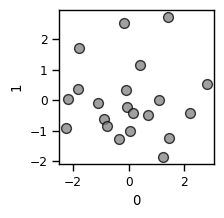

In [55]:
# plot first and second PC against each other
# data from last shuffle iteration run

hfig,ax = plt.subplots(1,figsize=(2,2))
sns.scatterplot(ax=ax,data=pivot_df,x='0',y='1',linewidth=1,color='gray',edgecolor='black',s=50,alpha = 0.75)


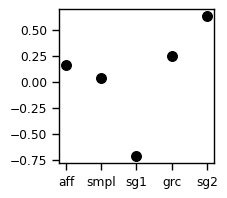

In [56]:
# plot loadings of features onto first principle component
# data from last shuffle iteration run

hfig,ax = plt.subplots(figsize = (2,2))
ax.scatter(target_types_order,[l[0] for l in loadings],color = 'black',s=50)

## plot comparison

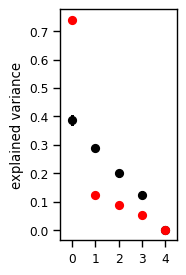

In [58]:
hfig,ax = plt.subplots(1,figsize=(1.5,3))

# plot iteration means
sns.pointplot(data = result_shuff,linestyle='',color = 'black',markersize = 5,errorbar='ci')
sns.pointplot(data=result_data,linestyle='',color = 'red',markersize = 5)

ax.set_ylabel('explained variance')
plt.savefig(f'/Users/kperks/Downloads/MG-Output_input_pca_compare.svg', format='svg', transparent=True)

## Use PCA module from https://erdogant.github.io/pca/pages/html/index.html

Has some useful plotting functions

In [20]:
from pca import pca

In [21]:
mask = df_syn[dsource].isin(source_types_order) & df_syn[dtarget].isin(target_types_order)  # Filter out rows with post_type not in post_groups and pre_type not in pre_groups
df_syn_data = df_syn[mask]

# get total synaptic weight between each pre-post cell pair
df_edges_data=df_syn_data[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

# Pivot table to get sum of weights per pre cell ID and post type
pivot_df = df_edges_data.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)

# Reindex columns to include only the specified pre_types in the desired order (for plotting purposes later)
pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)

# Reset index to turn 'post' and 'post_type' from index to columns
pivot_df.reset_index(inplace=True)

# Sort the dataframe based on post_type
pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
pivot_df.sort_values(dsource, inplace=True)
pivot_df.set_index(idsource, inplace=True)

# Apply the fraction total synapses normalization function to each row (each pre cell)
norm_df = pivot_df.select_dtypes(include='number').apply(calculate_percent_total, axis=1)

# Standardize the data for each feature
scaler = StandardScaler()
scaled_data = scaler.fit_transform(norm_df)

scaled_data = pd.DataFrame(scaled_data,columns=norm_df.columns)

In [22]:
scaled_data.head()

post_type,sg1,mg1,lg,sg2,mg2,lf
0,0.634936,-0.484841,-0.601919,-0.443921,1.218777,-0.653114
1,1.076934,-0.193661,0.171025,-0.443921,-0.377637,-0.151371
2,-0.580557,2.718138,-0.601919,-0.443921,-1.071730,-0.653114
3,-0.580557,0.716276,0.248319,-0.443921,-0.308227,-0.101196
4,0.432354,1.383563,-0.601919,-0.443921,-1.071730,0.266748


In [23]:
model = pca()

results = model.fit_transform(scaled_data);

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [6] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 5 Principal Components explain [100.0%] of the variance.'}, xlabel='Principal Component', ylabel='Percentage explained variance'>)

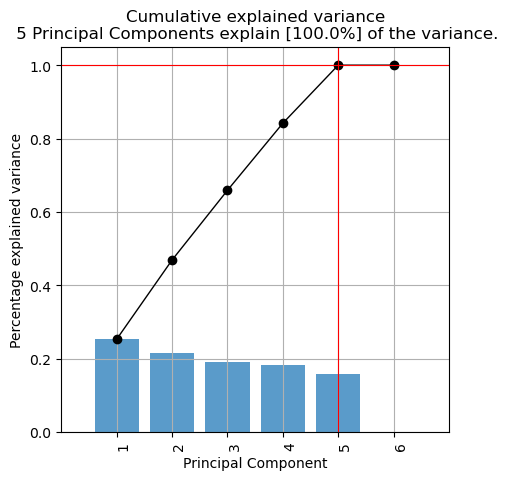

In [24]:
model.plot(figsize=(5,5))

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'5 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (25.2% expl.var)', ylabel='PC2 (21.5% expl.var)'>)

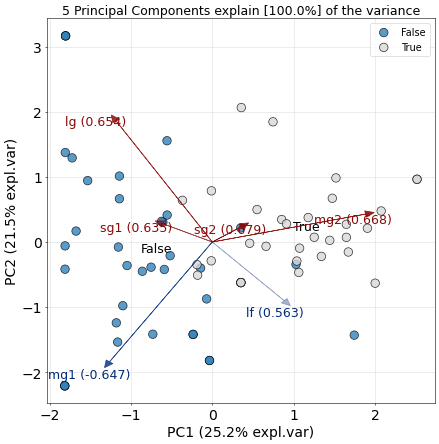

In [25]:
X_feat = norm_df['mg2'].values>np.mean(norm_df['mg2'].values)
model.biplot(figsize=(10, 10), dpi=50,labels=X_feat)
# plt.savefig('/Users/kperks/Downloads/pf_output_PCA_loadings_labeled-by-mg2.svg', format='svg', transparent=True)

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'5 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (25.2% expl.var)', ylabel='PC2 (21.5% expl.var)'>)

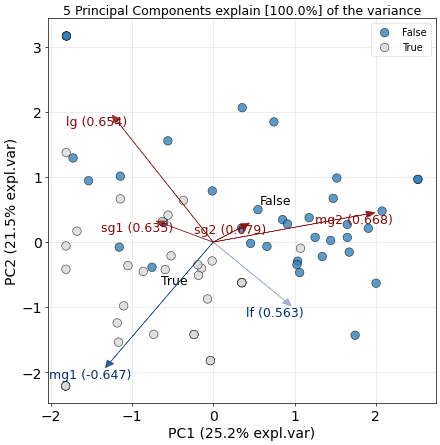

In [32]:
X_feat = norm_df['mg1'].values>np.mean(norm_df['mg1'].values)
model.biplot(figsize=(10, 10), dpi=50,labels=X_feat)
# plt.savefig('/Users/kperks/Downloads/pf_output_PCA_loadings_labeled-by-mg1.svg', format='svg', transparent=True)

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'5 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (25.2% expl.var)', ylabel='PC2 (21.5% expl.var)'>)

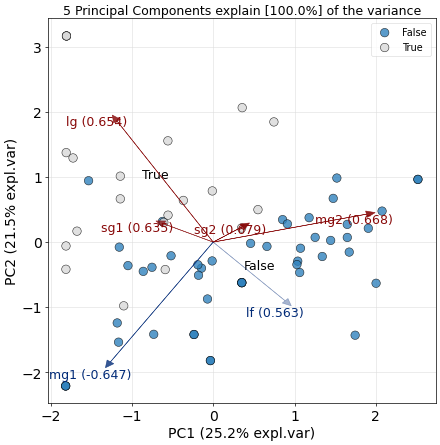

In [33]:
X_feat = norm_df['lg'].values>np.mean(norm_df['lg'].values)
model.biplot(figsize=(10, 10), dpi=50,labels=X_feat)

[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 500x500 with 1 Axes>,
 <Axes3DSubplot:title={'center':'Color on flavanoids (Gray colored samples are > mean)'}, xlabel='PC1 (25.2% expl.var)', ylabel='PC2 (21.5% expl.var)'>)

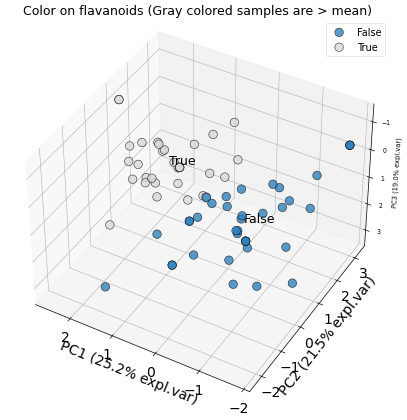

In [34]:

# Grap the values for mg2 syn and # Color based on mean
X_feat = norm_df['mg2'].values>np.mean(norm_df['mg2'].values)

# Scatter based on discrete color
model.scatter3d(labels=X_feat, title='Color on flavanoids (Gray colored samples are > mean)',figsize=(10,10),dpi=50)

# 3d scatter plot
# model.scatter3d(labels=color_label, title='Color on flavanoids (Gray colored samples are > mean)')

## Larry's code translated from Matlab to python

Step 1: Load the Data
The script starts by reading data from three CSV files:

df_pfsyn.csv: Contains some kind of pre- and post-synaptic connection data related to "PF" (maybe parallel fibers?).
df_postsyn_mg.csv: Another dataset with pre- and post-synaptic connection data, but for "MG" (possibly mossy glomeruli?).
df_type.csv: Contains a list of different cell types, their IDs, and names.
Once the data is loaded, it extracts specific columns from each table, converting them into arrays for easier manipulation.

Step 2: Identify Different Cell Types
The script then filters the cell IDs based on their names. Essentially, it looks at the list of cells and says:
"Give me all the cell IDs that belong to 'mg1', 'mg2', 'sg1', etc."
It does this for different types of neurons or structures, storing the IDs separately.

Step 3: Build Connection Matrices
The function makeConnects is used here to figure out which cells are connected to which.

For example, MG1ToLF = makeConnects(preMG, postMG, MG1ID, LFID);
This means:
"Find all the connections where 'MG1' is the presynaptic cell and 'LF' is the postsynaptic cell, and store them in a matrix."

The script does this for every combination of cell types, creating a set of matrices that represent the connectivity.

Step 4: Perform Singular Value Decomposition (SVD)
After building these connection matrices, the script runs SVD on them using the doSVD function. This essentially breaks down each connectivity matrix into its fundamental components, helping to identify major patterns in the connectivity data.

At the same time, it runs a randomized version of the SVD (by shuffling the data) to compare the real structure against randomly generated noise.

Step 5: Visualizing the Connection Data
The script then creates a bunch of figures using pcolor, which is like a heatmap. Each subplot represents how strongly different cell types are connected to each other.

In [374]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def make_connects(L1, L2, ID1, ID2):
    M = np.zeros((len(ID1), len(ID2)))
    for i, id1 in enumerate(ID1):
        i_pre = np.where(L1 == id1)[0]
        for j, id2 in enumerate(ID2):
            i_syn = np.where(L2[i_pre] == id2)[0]
            M[i, j] = len(i_syn)
    return M

def do_svd(M):
    isfull= M.shape[0] >= M.shape[1]
    S1 = np.linalg.svd(M, full_matrices=isfull, compute_uv=False)
    S1 = 100 * S1 / np.sum(S1)
    S2_all = np.zeros((100, len(S1)))
    for i in range(100):
        i_ran = np.random.permutation(np.prod(M_.shape))
        M_ran = M.flatten()[i_ran].reshape(M.shape)
        S2_all[i, :] = np.linalg.svd(M_ran, full_matrices = isfull, compute_uv=False)
        S2_all[i, :] = 100 * S2_all[i, :] / np.sum(S2_all[i, :])
    S2 = np.mean(S2_all, axis=0)
    sigS = np.std(S2_all, axis=0)
    return S1, S2, sigS

In [ ]:
# # Load data
# data_pre_pf = pd.read_csv("df_pfsyn.csv")
# data_pre_mg = pd.read_csv("df_postsyn_mg.csv")
# data_id = pd.read_csv("df_type.csv")

In [375]:
# dirpath = Path('<path to folder with file>')
dirpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/graphs')
data_pre_pf = pd.read_csv(dirpath / 'df_pfsyn.csv') #df_pfsyn #df_presyn_filt #df_postsyn_mg


In [376]:
# dirpath = Path('<path to folder with file>')
dirpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/metadata')
data_id = pd.read_csv(dirpath / 'df_type.csv')


In [377]:
cell_id = data_id.iloc[:, 1].to_numpy()
cell_name = data_id.iloc[:, 2].to_numpy()
# pre_mg = data_pre_mg.iloc[:, 1].to_numpy()
# post_mg = data_pre_mg.iloc[:, 2].to_numpy()
pre_pf = data_pre_pf.iloc[:, 1].to_numpy()
post_pf = data_pre_pf.iloc[:, 2].to_numpy()

In [378]:
print(f'{len(pre_pf)} synapses from {len(np.unique(pre_pf))} granule axons to {len(np.unique(post_pf))} spiny cells')


1084 synapses from 73 granule axons to 567 spiny cells


In [379]:
# Cell type IDs
MG1ID = cell_id[cell_name == "mg1"]
MG2ID = cell_id[cell_name == "mg2"]
SG1ID = cell_id[cell_name == "sg1"]
SG2ID = cell_id[cell_name == "sg2"]
LFID = cell_id[cell_name == "lf"]
LGID = cell_id[cell_name == "lg"]
PFID = cell_id[cell_name == "pf"]

In [380]:
# Generate connection matrices
# PFToLF = make_connects(pre_pf, post_pf, PFID, LFID)


# def make_connects(L1, L2, ID1, ID2):
#     M = np.zeros((len(ID1), len(ID2)))
#     for i, id1 in enumerate(ID1):
#         i_pre = np.where(L1 == id1)[0]
#         for j, id2 in enumerate(ID2):
#             i_syn = np.where(L2[i_pre] == id2)[0]
#             M[i, j] = len(i_syn)
#     return M

L1 = pre_pf
L2 = post_pf
ID1 = PFID
ID2 = LFID

M = np.zeros((len(ID1), len(ID2)))

for i, id1 in enumerate(ID1):
    i_pre = np.where(L1 == id1)[0]
    for j, id2 in enumerate(ID2):
        i_syn = np.where(L2[i_pre] == id2)[0]
        M[i, j] = len(i_syn)

In [381]:
# Generate connection matrices
# MG1ToLF = make_connects(pre_mg, post_mg, MG1ID, LFID)
# MG1ToLG = make_connects(pre_mg, post_mg, MG1ID, LGID)
# MG2ToLF = make_connects(pre_mg, post_mg, MG2ID, LFID)
# MG2ToLG = make_connects(pre_mg, post_mg, MG2ID, LGID)
# MG1ToMG1 = make_connects(pre_mg, post_mg, MG1ID, MG1ID)
# MG1ToMG2 = make_connects(pre_mg, post_mg, MG1ID, MG2ID)
# MG2ToMG1 = make_connects(pre_mg, post_mg, MG2ID, MG1ID)
# MG2ToMG2 = make_connects(pre_mg, post_mg, MG2ID, MG2ID)
PFToLF = make_connects(pre_pf, post_pf, PFID, LFID)
PFToLG = make_connects(pre_pf, post_pf, PFID, LGID)
PFToMG1 = make_connects(pre_pf, post_pf, PFID, MG1ID)
PFToMG2 = make_connects(pre_pf, post_pf, PFID, MG2ID)
PFToSG1 = make_connects(pre_pf, post_pf, PFID, SG1ID)
PFToSG2 = make_connects(pre_pf, post_pf, PFID, SG2ID)

In [382]:
# MGToOut = np.vstack([np.hstack([MG1ToLF, MG1ToLG]), np.hstack([MG2ToLF, MG2ToLG])])
PFToOut = np.hstack([PFToLF, PFToLG, PFToMG1, PFToMG2, PFToSG1, PFToSG2])

In [383]:
np.shape(PFToOut)

(206, 804)

<AxesSubplot:>

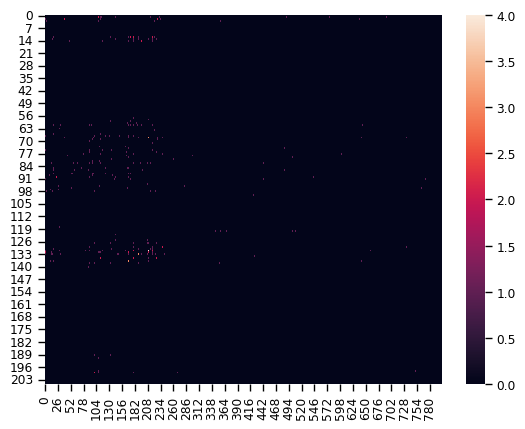

In [108]:
sns.heatmap(PFToOut)

In [384]:
np.linalg.matrix_rank(PFToOut) == min(PFToOut.shape)

#if false, there are dependent columns and it is not full rank

False

In [385]:
# SPF, SRanPF, sigSPF = do_svd(PFToOut)
# def do_svd(M):
#     S1 = np.linalg.svd(M, compute_uv=False)
#     S1 = 100 * S1 / np.sum(S1)
#     S2_all = np.zeros((100, len(S1)))
#     for i in range(100):
#         i_ran = np.random.permutation(M.size)
#         M_ran = M.flatten()[i_ran].reshape(M.shape)
#         S2_all[i, :] = np.linalg.svd(M_ran, compute_uv=False)
#         S2_all[i, :] = 100 * S2_all[i, :] / np.sum(S2_all[i, :])
#     S2 = np.mean(S2_all, axis=0)
#     sigS = np.std(S2_all, axis=0)
#     return S1, S2, sigS

M = PFToOut

#data
S1 = np.linalg.svd(M, full_matrices=np.linalg.matrix_rank(PFToOut) == min(PFToOut.shape), compute_uv=False)
# S1 = np.diag(S1)
S1 = 100 * S1 / np.sum(S1)

In [386]:
len(S1)

206

In [ ]:
#shuffle
S2_all = np.zeros((100, len(S1)))
for i in range(100):
    i_ran = np.random.permutation(M.size)
    M_ran = M.flatten()[i_ran].reshape(M.shape)
    S2_all[i, :] = np.linalg.svd(M_ran, compute_uv=False)
    S2_all[i, :] = 100 * S2_all[i, :] / np.sum(S2_all[i, :])
S2 = np.mean(S2_all, axis=0)
sigS = np.std(S2_all, axis=0)

In [160]:
# SMG, SRanMG, sigSMG = do_svd(MGToOut)
SPF, SRanPF, sigSPF = do_svd(PFToOut)

In [116]:
# Plot connection matrices
def plot_matrix(data, xlabel, ylabel, title):
    plt.figure()
    plt.pcolor(data.T, cmap='Blues')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.colorbar()
    plt.box(False)
    plt.show()

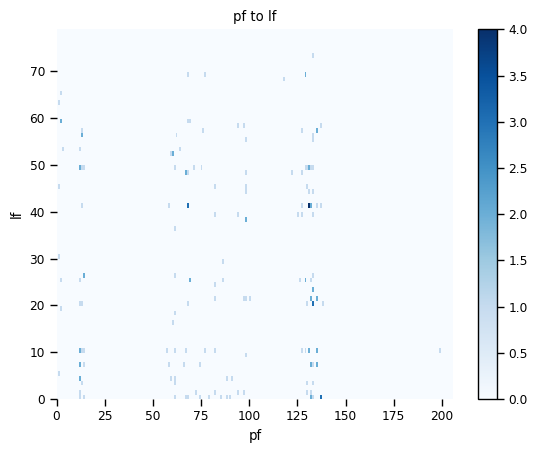

In [137]:
plot_matrix(PFToMG2,'pf','lf','pf to lf')

In [ ]:
# plot_matrix(MG1ToLF, "MG1", "LF", "MG1 to LF")
# plot_matrix(MG2ToLF, "MG2", "LF", "MG2 to LF")
# plot_matrix(MG1ToLG, "MG1", "LG", "MG1 to LG")
# plot_matrix(MG2ToLG, "MG2", "LG", "MG2 to LG")

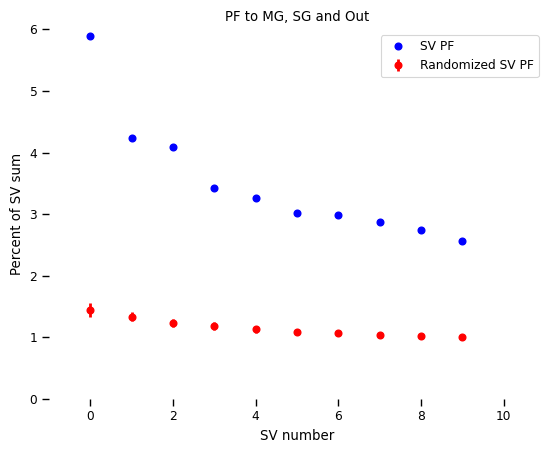

In [161]:
# # Plot SVD results
# plt.figure()
# plt.plot(SMG[:10], 'bo', linewidth=2, label='SV MG')
# plt.errorbar(range(10), SRanMG[:10], yerr=sigSMG[:10], fmt='ro', linewidth=2, label='Randomized SV MG')
# plt.xlim([0, 10])
# plt.ylim([0, 5])
# plt.xlabel("SV number")
# plt.ylabel("Percent of SV sum")
# plt.title("MG to Out")
# plt.legend()
# plt.box(False)
# plt.show()

plt.figure()
plt.plot(SPF[:10], 'bo', linewidth=2, label='SV PF')
plt.errorbar(range(10), SRanPF[:10], yerr=sigSPF[:10], fmt='ro', linewidth=2, label='Randomized SV PF')
plt.xlim([-1, 11])
plt.ylim([0, 6])
plt.xlabel("SV number")
plt.ylabel("Percent of SV sum")
plt.title("PF to MG, SG and Out")
plt.legend()
plt.box(False)
plt.show()

### Larry's svd/pca code cleaned up more for python and my data

In [208]:
def import_dsyn_with_type(syn_file,dtype_file):
    df_syn = pd.read_csv(syn_file)
    df_type = pd.read_csv(dtype_file)
    for i,r in df_syn.iterrows():
        try:
            df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
            df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
        except:
            print(r['pre'],r['post'])
            continue
    
    df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
    df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

    return df_syn

In [361]:
def get_connect(df_syn, columns):# Get unique 'pre' and 'post' values
    '''
    columns: which columns to use for connection counts: ['pre','post'] gets connectivity by cell pairs while ['pre','post_type'] gets connectivity by pre cell - post type relationship
    '''
    df_edges = df_syn[columns].value_counts().reset_index(name='weight')

    m_cells = df_edges[columns[0]].unique()
    n_cells = df_edges[columns[1]].unique()
    
    # Create index mappings
    m_index = {cell: idx for idx, cell in enumerate(m_cells)}
    n_index = {cell: idx for idx, cell in enumerate(n_cells)}
    
    # Initialize the adjacency matrix
    matrix = np.zeros((len(m_cells), len(n_cells)))
    
    # Populate the matrix
    for _, row in df_edges.iterrows():
        i = m_index[row[columns[0]]]
        j = n_index[row[columns[1]]]
        matrix[i, j] = row['weight']

    m_labels=m_cells
    n_labels=n_cells
    return matrix, m_labels, n_labels


def plot_connect(matrix,index_,columns_):
    # Convert matrix to a DataFrame for better visualization
    matrix_df = pd.DataFrame(M, index=index_, columns=columns_) #EX: index_=pre_cells and columns_=post_cells
    
    # Display the result
    sns.heatmap(matrix_df, xticklabels=False, yticklabels=False)

In [392]:
def do_svd(M):
    isfull= M.shape[0] >= M.shape[1]
    S = np.linalg.svd(M, full_matrices=isfull, compute_uv=False)
    S = 100 * S / np.sum(S)
    
    return S

In [402]:
def do_pca(M,n_feat):
    # Apply the fraction total synapses normalization function to each row (each pre cell)

    '''
    pca_result: the data projected into PC space -- ie. scatter(pca_result[:,0],pca_result[:,1]) plots the second principle component against the 3rd to see how the data clusters or not in the space according to other features
    '''
    
    # Perform PCA
    pca_ = PCA(n_components=n_feat)  
    
    pca_result = pca_.fit_transform(M)
    
    # get loadings of dimensions onto each principal component
    loadings = pca_.components_.T

    return pca_, pca_result, loadings

In [461]:
def do_decomposition(df_syn,columns,norm_row,n_reps,n_feat,which_shuff,how_shuff):
    '''
    This function performs both direct svd via numpy.linalg.svd and pca (and svd) via scikit learn decomposition module. scikit pca also returns the svd result so can compare to direct svd via numpy.

    Data can be shuffled and analyzed on each iteration or just analyzed one time. If shuffled across multiple iterations, only the last model fit is returned -- the rest of the results are appended to an array and the mean and std are returned (std = [] if nreps=1)
    
    df_syn: original data in which each row is a single synapse
    columns: which columns to use for connection counts
    nreps: n_reps=1 for data or n_reps>1 for shuffle
    n_feat: number of features to analyze -- only used for pca (svd uses all columns/features)
    which_shuff: whether to shuffle 'synapses' or 'weights'
    how_shuff: only applies if which_shuff=='weights' because it changes whether whole matrix is shuffled around or if shuffles are constrained across rows
    '''
    M_, m_labels, n_labels = get_connect(df_syn, columns)
    
    S = np.zeros((n_reps, n_feat))
    E = np.zeros((n_reps, n_feat))
    E_S = np.zeros((n_reps, n_feat))
    
    for i in range(n_reps):

        if n_reps == 1:
            if norm_row==True:
                M = M_ / M_.sum(axis=1, keepdims=True)
            if norm_row==False:
                M=M_
                
        if n_reps > 1:
            
            if which_shuff=='synapses':
                '''shuffling synapses is more similar to shuffling "all" in connectivity matrix than "rows"'''
                df_syn_shuff = df_syn[columns].apply(np.random.permutation, axis=0)
                M, _, _ = get_connect(df_syn_shuff, columns)
                if norm_row==True:
                    M = M / M.sum(axis=1, keepdims=True)
    
            if which_shuff=='weights':
                # df_syn_shuff = df_syn[columns].apply(np.random.permutation, axis=0)
                # M, _, _ = get_connect(df_syn_shuff, columns)

                if how_shuff=='rows':
                    '''randomize connections across each row (so each m cell has the same number of synapses/weights, but onto different n cells)'''
                    # **NOTE that in Larry analysis, the synapses are totally shuffled across entire matrix so m cells end up with different number of synapses**
                    df = pd.DataFrame(M_)
                    df = df.apply(lambda x: np.random.permutation(x), axis=1, raw=True)
                    M = df.values

                if how_shuff=='all':
                    ''' to do the type of shuffle larry did:'''
                    i_ran = np.random.permutation(np.prod(M_.shape))
                    M = M_.flatten()[i_ran].reshape(M_.shape)
                
                if norm_row==True:
                    M = M / M.sum(axis=1, keepdims=True)
    
        scaler = StandardScaler()
        M = scaler.fit_transform(M)
    
        S_ = do_svd(M)
        S[i, :] = S_

        pca_, pca_result, loadings = do_pca(M,n_feat)
        E[i,:]= pca_.explained_variance_ratio_

        E_S_ =  pca_.singular_values_ 
        E_S[i,:]= 100 * E_S_ / np.sum(E_S_)
        
    sigS = []
    if n_reps>1:
        sigS = np.std(S, axis=0)
    S = np.mean(S, axis=0)     
    
    sigE = []
    if n_reps>1:
        sigE = np.std(E, axis=0)
    E = np.mean(E, axis=0)   

    sigE_S = []
    if n_reps>1:
        sigE_S = np.std(E_S, axis=0)
    E_S = np.mean(E_S, axis=0)   

    return m_labels, n_labels, E, sigE, E_S, sigE_S, S, sigS, pca_result, loadings

In [453]:
do_svd(np.asarray([[1,2,3],[3,4,5]]))#,[5,6]]))

array([92.85047587,  7.14952413])

In [353]:

dirpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/graphs')
syn_file = dirpath / 'df_pfsyn.csv'

dirpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/metadata')
dtype_file = dirpath / 'df_type.csv'

df_syn = import_dsyn_with_type(syn_file,dtype_file)

In [354]:
df_syn.head()

,Unnamed: 0,pre,post,structure,x,y,z,pre_type,post_type
0,0,102463116,21188272,unknown,254372,102268,15885,pf,fov
1,1,102463116,19996911,unknown,238059,98249,22125,pf,fov
2,2,102463116,19996911,unknown,237152,97488,21975,pf,fov
3,3,117041378,42644625,apical dendrite,115503,196503,19515,pf,sg1
4,4,117041378,214411806,apical dendrite,152435,195162,31365,pf,mg1


In [355]:
mask = df_syn[dsource].isin(source_types_order) & df_syn[dtarget].isin(target_types_order)  # Filter out rows with post_type not in post_groups and pre_type not in pre_groups
df_syn_data = df_syn[mask]

#### shuffle connection weights with features post cells

In [ ]:
columns=['pre','post']
norm_row=False
n_reps=1
n_feat=np.min([len(df_syn_data[columns[0]].unique()),len(df_syn_data[columns[1]].unique())])
which_shuff='weights'
how_shuff='all'
m_labels, n_labels, E, sigE, E_S, sigE_S, S, sigS, pca_result, loadings = do_decomposition(df_syn_data,columns,norm_row,n_reps,n_feat,which_shuff,how_shuff)

n_reps=100
m_labels, n_labels, E_ran, sigE, E_S_ran, sigE_S, S_ran, sigS, pca_result_ran, loadings_ran = do_decomposition(df_syn_data,columns,norm_row,n_reps,n_feat,which_shuff,how_shuff)

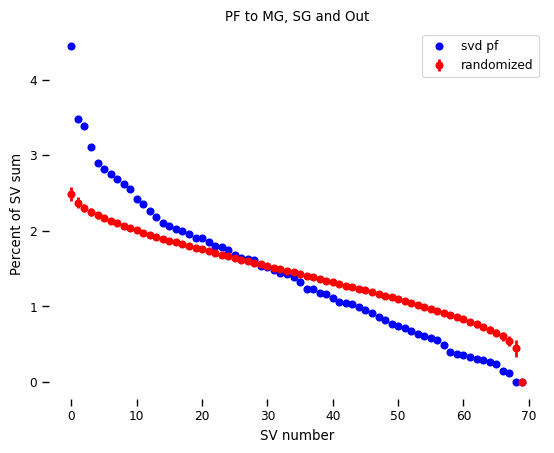

In [446]:

plt.figure()
plt.plot(range(len(S)),S, 'bo', linewidth=2, label='svd pf')
plt.errorbar(range(len(S_ran)),S_ran,yerr=sigS,fmt='ro',linewidth=2,label='randomized')
# plt.errorbar(range(10), SranU[:10], yerr=sigS[:10], fmt='ro', linewidth=2, label='Randomized SV PF')
# plt.xlim([-1, 11])
# plt.ylim([0, 6])
plt.xlabel("SV number")
plt.ylabel("Percent of SV sum")
plt.title("PF to MG, SG and Out")
plt.legend()
plt.box(False)
plt.show()

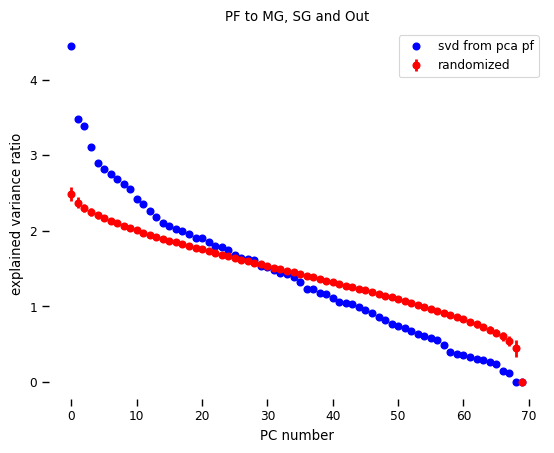

In [448]:

plt.figure()
plt.plot(range(len(E_S)),E_S, 'bo', linewidth=2, label='svd from pca pf')
plt.errorbar(range(len(E_S_ran)),E_S_ran,yerr=sigE_S,fmt='ro',linewidth=2,label='randomized')
# plt.errorbar(range(10), SranU[:10], yerr=sigS[:10], fmt='ro', linewidth=2, label='Randomized SV PF')
# plt.xlim([-1, 11])
# plt.ylim([0, 6])
plt.xlabel("PC number")
plt.ylabel("explained variance ratio")
plt.title("PF to MG, SG and Out")
plt.legend()
plt.box(False)
plt.show()

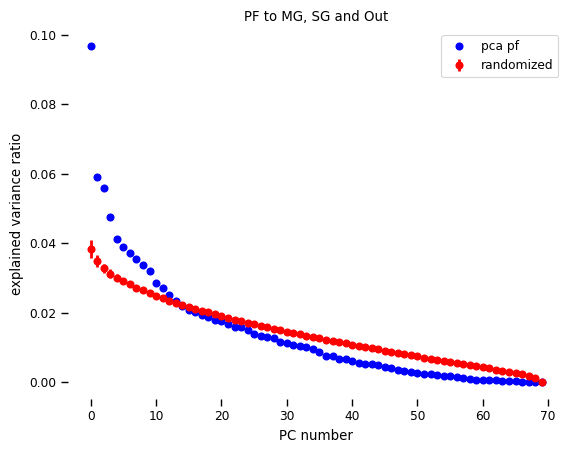

In [447]:

plt.figure()
plt.plot(range(len(E)),E, 'bo', linewidth=2, label='pca pf')
plt.errorbar(range(len(E_ran)),E_ran,yerr=sigE,fmt='ro',linewidth=2,label='randomized')
# plt.errorbar(range(10), SranU[:10], yerr=sigS[:10], fmt='ro', linewidth=2, label='Randomized SV PF')
# plt.xlim([-1, 11])
# plt.ylim([0, 6])
plt.xlabel("PC number")
plt.ylabel("explained variance ratio")
plt.title("PF to MG, SG and Out")
plt.legend()
plt.box(False)
plt.show()

#### shuffle connection SYNAPSES with features post cells

In [477]:
columns=['pre','post']
norm_row=False
n_reps=1
n_feat=np.min([len(df_syn_data[columns[0]].unique()),len(df_syn_data[columns[1]].unique())])
which_shuff='synapses'
how_shuff='all'#'rows'#
m_labels, n_labels, E, sigE, E_S, sigE_S, S, sigS, pca_result, loadings = do_decomposition(df_syn_data,columns,norm_row,n_reps,n_feat,which_shuff,how_shuff)

n_reps=100
m_labels, n_labels, E_ran, sigE, E_S_ran, sigE_S, S_ran, sigS, pca_result_ran, loadings_ran = do_decomposition(df_syn_data,columns,norm_row,n_reps,n_feat,which_shuff,how_shuff)

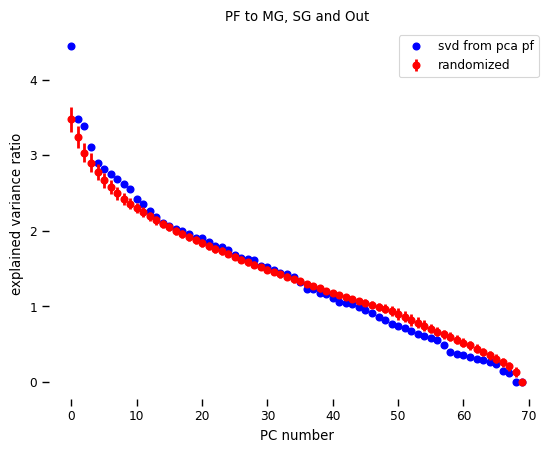

In [478]:

plt.figure()
plt.plot(range(len(E_S)),E_S, 'bo', linewidth=2, label='svd from pca pf')
plt.errorbar(range(len(E_S_ran)),E_S_ran,yerr=sigE_S,fmt='ro',linewidth=2,label='randomized')
# plt.errorbar(range(10), SranU[:10], yerr=sigS[:10], fmt='ro', linewidth=2, label='Randomized SV PF')
# plt.xlim([-1, 11])
# plt.ylim([0, 6])
plt.xlabel("PC number")
plt.ylabel("explained variance ratio")
plt.title("PF to MG, SG and Out")
plt.legend()
plt.box(False)
plt.show()

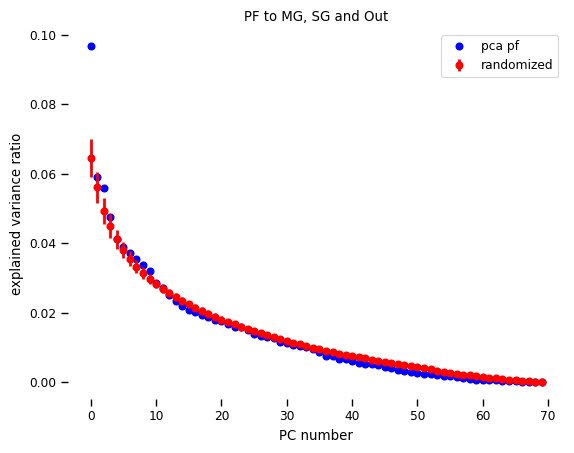

In [479]:

plt.figure()
plt.plot(range(len(E)),E, 'bo', linewidth=2, label='pca pf')
plt.errorbar(range(len(E_ran)),E_ran,yerr=sigE,fmt='ro',linewidth=2,label='randomized')
# plt.errorbar(range(10), SranU[:10], yerr=sigS[:10], fmt='ro', linewidth=2, label='Randomized SV PF')
# plt.xlim([-1, 11])
# plt.ylim([0, 6])
plt.xlabel("PC number")
plt.ylabel("explained variance ratio")
plt.title("PF to MG, SG and Out")
plt.legend()
plt.box(False)
plt.show()

#### shuffle connection weights with features post TYPE

In [465]:
columns=['pre','post_type']
norm_row=False
n_reps=1
n_feat=np.min([len(df_syn_data[columns[0]].unique()),len(df_syn_data[columns[1]].unique())])
which_shuff='weights'
how_shuff='all' #'rows' #
m_labels, n_labels, E, sigE, E_S, sigE_S, S, sigS, pca_result, loadings = do_decomposition(df_syn_data,columns,norm_row,n_reps,n_feat,which_shuff,how_shuff)

n_reps=100
m_labels, n_labels, E_ran, sigE, E_S_ran, sigE_S, S_ran, sigS, pca_result_ran, loadings_ran = do_decomposition(df_syn_data,columns,norm_row,n_reps,n_feat,which_shuff,how_shuff)

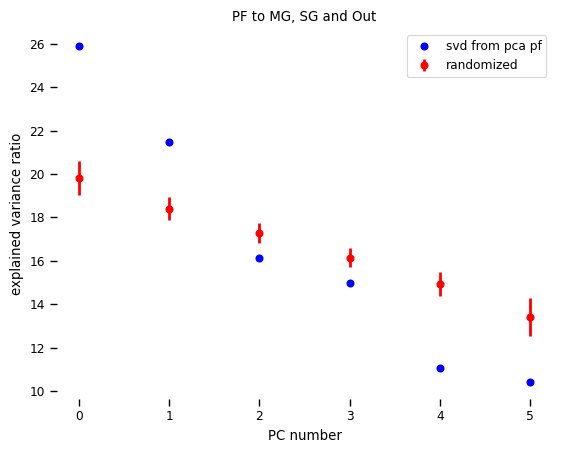

In [466]:

plt.figure()
plt.plot(range(len(E_S)),E_S, 'bo', linewidth=2, label='svd from pca pf')
plt.errorbar(range(len(E_S_ran)),E_S_ran,yerr=sigE_S,fmt='ro',linewidth=2,label='randomized')
# plt.errorbar(range(10), SranU[:10], yerr=sigS[:10], fmt='ro', linewidth=2, label='Randomized SV PF')
# plt.xlim([-1, 11])
# plt.ylim([0, 6])
plt.xlabel("PC number")
plt.ylabel("explained variance ratio")
plt.title("PF to MG, SG and Out")
plt.legend()
plt.box(False)
plt.show()

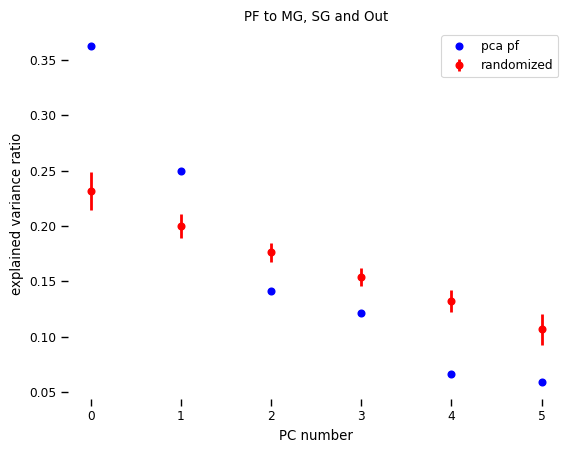

In [467]:

plt.figure()
plt.plot(range(len(E)),E, 'bo', linewidth=2, label='pca pf')
plt.errorbar(range(len(E_ran)),E_ran,yerr=sigE,fmt='ro',linewidth=2,label='randomized')
# plt.errorbar(range(10), SranU[:10], yerr=sigS[:10], fmt='ro', linewidth=2, label='Randomized SV PF')
# plt.xlim([-1, 11])
# plt.ylim([0, 6])
plt.xlabel("PC number")
plt.ylabel("explained variance ratio")
plt.title("PF to MG, SG and Out")
plt.legend()
plt.box(False)
plt.show()

#### shuffle SYNAPSES with features post TYPE

In [457]:
columns=['pre','post_type']
norm_row=False
n_reps=1
n_feat=np.min([len(df_syn_data[columns[0]].unique()),len(df_syn_data[columns[1]].unique())])
which_shuff='synapses'
how_shuff=''
m_labels, n_labels, E, sigE, E_S, sigE_S, S, sigS, pca_result, loadings = do_decomposition(df_syn_data,columns,norm_row,n_reps,n_feat,which_shuff,how_shuff)

n_reps=100
m_labels, n_labels, E_ran, sigE, E_S_ran, sigE_S, S_ran, sigS, pca_result_ran, loadings_ran = do_decomposition(df_syn_data,columns,norm_row,n_reps,n_feat,which_shuff,how_shuff)

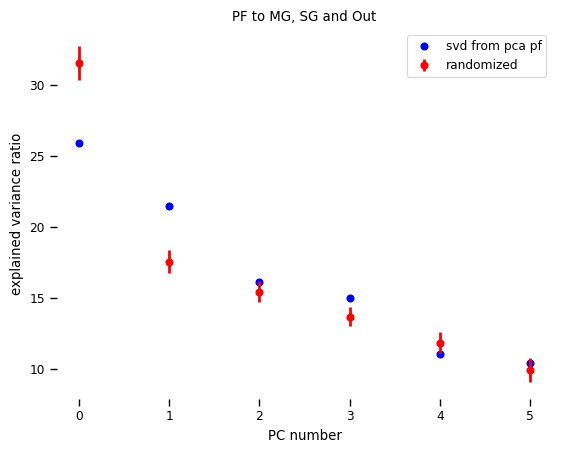

In [458]:

plt.figure()
plt.plot(range(len(E_S)),E_S, 'bo', linewidth=2, label='svd from pca pf')
plt.errorbar(range(len(E_S_ran)),E_S_ran,yerr=sigE_S,fmt='ro',linewidth=2,label='randomized')
# plt.errorbar(range(10), SranU[:10], yerr=sigS[:10], fmt='ro', linewidth=2, label='Randomized SV PF')
# plt.xlim([-1, 11])
# plt.ylim([0, 6])
plt.xlabel("PC number")
plt.ylabel("explained variance ratio")
plt.title("PF to MG, SG and Out")
plt.legend()
plt.box(False)
plt.show()

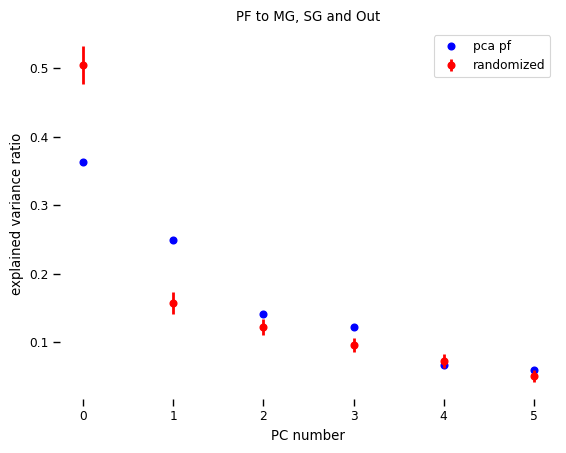

In [459]:

plt.figure()
plt.plot(range(len(E)),E, 'bo', linewidth=2, label='pca pf')
plt.errorbar(range(len(E_ran)),E_ran,yerr=sigE,fmt='ro',linewidth=2,label='randomized')
# plt.errorbar(range(10), SranU[:10], yerr=sigS[:10], fmt='ro', linewidth=2, label='Randomized SV PF')
# plt.xlim([-1, 11])
# plt.ylim([0, 6])
plt.xlabel("PC number")
plt.ylabel("explained variance ratio")
plt.title("PF to MG, SG and Out")
plt.legend()
plt.box(False)
plt.show()

#### shuffle (constrained across row) connection weights with features post TYPE

In [468]:
columns=['pre','post_type']
norm_row=False
n_reps=1
n_feat=np.min([len(df_syn_data[columns[0]].unique()),len(df_syn_data[columns[1]].unique())])
which_shuff='weights'
how_shuff='rows' #'all' #
m_labels, n_labels, E, sigE, E_S, sigE_S, S, sigS, pca_result, loadings = do_decomposition(df_syn_data,columns,norm_row,n_reps,n_feat,which_shuff,how_shuff)

n_reps=100
m_labels, n_labels, E_ran, sigE, E_S_ran, sigE_S, S_ran, sigS, pca_result_ran, loadings_ran = do_decomposition(df_syn_data,columns,norm_row,n_reps,n_feat,which_shuff,how_shuff)

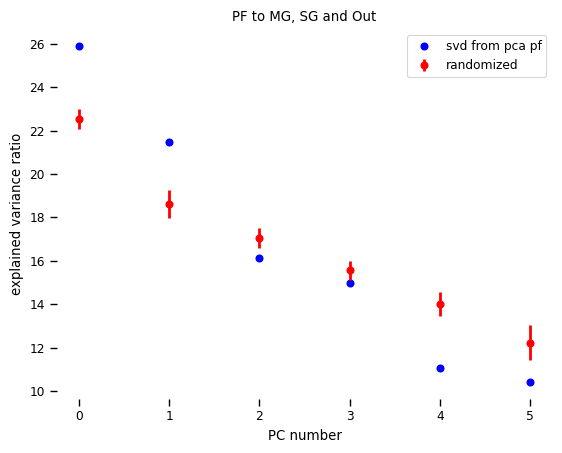

In [469]:

plt.figure()
plt.plot(range(len(E_S)),E_S, 'bo', linewidth=2, label='svd from pca pf')
plt.errorbar(range(len(E_S_ran)),E_S_ran,yerr=sigE_S,fmt='ro',linewidth=2,label='randomized')
# plt.errorbar(range(10), SranU[:10], yerr=sigS[:10], fmt='ro', linewidth=2, label='Randomized SV PF')
# plt.xlim([-1, 11])
# plt.ylim([0, 6])
plt.xlabel("PC number")
plt.ylabel("explained variance ratio")
plt.title("PF to MG, SG and Out")
plt.legend()
plt.box(False)
plt.show()

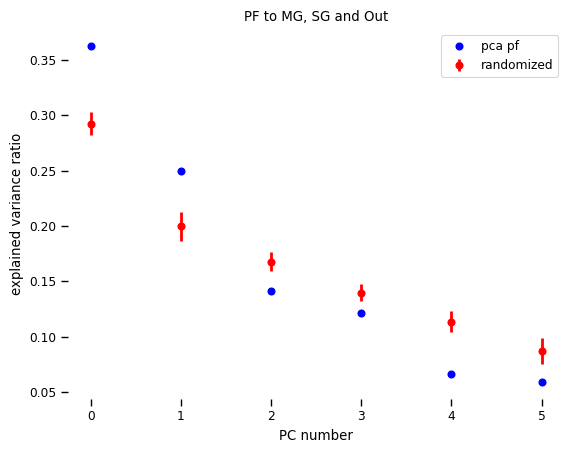

In [470]:

plt.figure()
plt.plot(range(len(E)),E, 'bo', linewidth=2, label='pca pf')
plt.errorbar(range(len(E_ran)),E_ran,yerr=sigE,fmt='ro',linewidth=2,label='randomized')
# plt.errorbar(range(10), SranU[:10], yerr=sigS[:10], fmt='ro', linewidth=2, label='Randomized SV PF')
# plt.xlim([-1, 11])
# plt.ylim([0, 6])
plt.xlabel("PC number")
plt.ylabel("explained variance ratio")
plt.title("PF to MG, SG and Out")
plt.legend()
plt.box(False)
plt.show()

In [209]:
# post-synaptic labeling
dsource = 'pre_type'
idsource = 'pre'
dtarget = 'post_type'
idtarget = 'post'

# Desired source_types and order
source_types_order = ['pf'] #['mg1','lg', 'mg2','lf'] #['mg1','mg2'] #
# Desired target_types and order
target_types_order = ['sg1', 'mg1','lg', 'sg2','mg2','lf']  #['aff','smpl','sg1','grc','sg2'] #['mg1','lg', 'mg2','lf'] #

### SVG vs PCA
Here's a Python example that demonstrates the difference between Singular Value Decomposition (SVD) and Principal Component Analysis (PCA) using a synthetic dataset.

Key Steps in the Example:  
- Generate a dataset with correlated features.
- Perform PCA using sklearn.decomposition.PCA.
- Perform SVD using numpy.linalg.svd.
- Compare results to see how PCA relates to SVD.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Generate synthetic data (correlated features)
np.random.seed(42)
X = np.dot(np.random.rand(2, 2), np.random.randn(2, 200)).T  # 200 samples, 2 features

# 2. Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 3. Perform SVD
X_centered = X - X.mean(axis=0)  # Centering the data
U, S, Vt = np.linalg.svd(X_centered)  # SVD decomposition

# 4. Compare results
print("Principal Components (from PCA):\n", pca.components_)
print("Right Singular Vectors (from SVD):\n", Vt)

# 5. Visualizing Original Data and PCA/SVD Components
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot of the original data
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original Data')
for i in range(2):
    vector = pca.components_[i] * 2  # Scale for visualization
    ax[0].arrow(0, 0, vector[0], vector[1], color='red', width=0.02, label=f'PC {i+1}')
ax[0].set_title("PCA Components on Original Data")
ax[0].legend()
ax[0].axis('equal')

# Scatter plot of transformed data in PCA space
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, label='PCA Transformed Data')
ax[1].set_title("Data in PCA Transformed Space")
ax[1].axis('equal')

plt.show()


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Sample data
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Perform SVD
U, S, Vt = np.linalg.svd(X_std)

# Calculate the explained variance ratio
explained_variance_ratio = (S ** 2) / np.sum(S ** 2)

# Choose the number of components
n_components = 2

# Reconstruct the data with reduced dimensions
X_pca = U[:, :n_components] @ np.diag(S[:n_components])

# Verify with sklearn's PCA
pca = PCA(n_components=n_components)
X_pca_sklearn = pca.fit_transform(X_std)

print("PCA via SVD:")
print(X_pca)
print("PCA via sklearn:")
print(X_pca_sklearn)

# conditional OUTPUT analysis

In [26]:
def get_conditional_output(df_edges,normalize=False):
    '''get p(connect)'''
    df_map = df_edges.groupby(['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(index='pre', columns='post_type', values='weight').fillna(0).reset_index().set_index('pre')

    if normalize==True:
        df_map = df_map.div(df_map.sum(axis=1),axis=0)
        '''group data'''
        result = []
        for g in df_map.columns:
            result.append(list(df_map[(df_map[g] > 0.05)].mean().values)) # sets a threshold for what counts as any connection at all

    if normalize==False:
        '''group data'''
        result = []
        for g in df_map.columns:
            result.append(list(df_map[(df_map[g] > 1)].mean().values)) # sets a threshold for what counts as any connection at all

    order = df_map.columns
        
    return result,order

In [28]:
# change as needed based on which synapses table you import and which cell types you want to include
pre_groups = ['pf'] #['mg1','mg2'] #
post_groups = ['mg1','mg2','lg','lf','sg1','sg2'] #['mg1','mg2','lg','lf'] # 

### shuffle 

Get the statistics of the shuffled data to compare real data against

In [29]:
result_shuff = [] # initiate an array to accumulate the results of each shuffle iteration

# Iterate the specified number of times
for i in range(100):
    df_syn_shuff = deepcopy(df_syn) # by initiating with a deepcopy of original table, the randomization happens on the data each time rather than on the last randomization
    mask = df_syn_shuff['pre_type'].isin(pre_groups) & df_syn_shuff['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_types_order and pre_type not in pre_types_order
    df_syn_shuff = df_syn_shuff[mask]
    
    # Shuffle the dataframe
    shuff_rows = df_syn_shuff[['post','x','y','z','post_type']].sample(frac = 1) #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
    df_syn_shuff.loc[:,['post']] = shuff_rows['post'].values
    df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
    df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
    df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
    df_syn_shuff.loc[:,['post_type']] = shuff_rows['post_type'].values

    df_edges_shuff=df_syn_shuff[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

    result_,order = get_conditional_output(df_edges_shuff,normalize=True)
    
    # Append the result as a row to the result_df
    result_shuff.append(result_)

result_shuff = np.asarray(result_shuff)

u_mat = result_shuff.mean(axis=0)

std_mat = result_shuff.std(axis=0)

### data

In [30]:
df_syn_data = deepcopy(df_syn)
mask = df_syn_data['pre_type'].isin(pre_groups) & df_syn_data['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_groups and pre_type not in pre_groups
df_syn_data = df_syn_data[mask]

df_edges_data=df_syn_data[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

result_data,order = get_conditional_output(df_edges_data,normalize=True)

# Calculate the z-scores using the shuffle statistics
z_scores = (result_data - u_mat) / std_mat
z_scores[np.isclose(std_mat, 0)] = 0  # Replace z-scores with 0 where std is 0 # Handle cases where std_2d is zero to avoid division by zero


cond_input_mat = pd.DataFrame(z_scores,columns = order, index = order)

## plot result as heatmap

<AxesSubplot:xlabel='post_type', ylabel='post_type'>

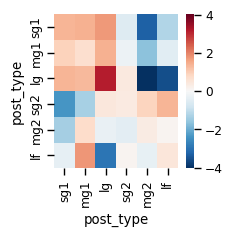

In [32]:

# Define the desired order for plotting
plot_order = ['sg1','mg1','lg','sg2','mg2','lf'] #['mg1','lg','mg2','lf']#

# Reorder rows and columns
df_reordered=cond_input_mat.reindex(index=plot_order, columns=plot_order)

# Ensure the color range is centered around 0
vmin = -max(abs(df_reordered.min().min()), abs(df_reordered.max().max()))
vmax = -vmin

sns.set_context("paper",font_scale=1)
hfig,ax = plt.subplots(1,figsize=(2,2))
sns.heatmap(df_reordered,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0)

# plt.savefig('/Users/kperks/Downloads/pf_output_conditional_output_analysis.svg', format='svg', transparent=True)

### an example of shuffle result

<AxesSubplot:xlabel='post_type', ylabel='post_type'>

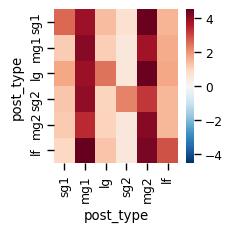

In [33]:

df_syn_shuff = deepcopy(df_syn)
mask = df_syn_shuff['pre_type'].isin(pre_groups) & df_syn_shuff['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
df_syn_shuff = df_syn_shuff[mask]
# Shuffle the dataframe
# df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
shuff_rows = df_syn_shuff[['pre','x','y','z','pre_type']].sample(frac = 1)
df_syn_shuff.loc[:,['pre']] = shuff_rows['pre'].values
df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
df_syn_shuff.loc[:,['pre_type']] = shuff_rows['pre_type'].values

df_edges_shuff=df_syn_shuff[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

result_,order = get_conditional_output(df_edges_shuff)

cond_input_mat = pd.DataFrame(result_,columns = order, index = order)

# Reorder rows and columns
df_reordered=cond_input_mat.reindex(index=plot_order, columns=plot_order)

# Ensure the color range is centered around 0
vmin = -max(abs(df_reordered.min().min()), abs(df_reordered.max().max()))
vmax = -vmin

hfig,ax = plt.subplots(1,figsize=(2,2))
sns.heatmap(df_reordered,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0)

# conditional INPUT analysis

In [65]:
def get_conditional_input(df_edges,normalize=False):
    '''get p(connect)'''
    df_map = df_edges.groupby(['post','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(index='post', columns='pre_type', values='weight').fillna(0).reset_index().set_index('post')

    if normalize==True:
        df_map = df_map.div(df_map.sum(axis=1),axis=0)
        '''group data'''
        result = []
        for g in df_map.columns:
            result.append(list(df_map[(df_map[g] > 0.05)].mean().values)) # sets a threshold for what counts as any connection at all

    if normalize==False:
        '''group data'''
        result = []
        for g in df_map.columns:
            result.append(list(df_map[(df_map[g] > 1)].mean().values)) # sets a threshold for what counts as any connection at all

    order = df_map.columns
    
    return result,order


In [60]:
# change as needed based on which synapses table you import and which cell types you want to include
pre_groups = ['aff','smpl','sg1','grc','sg2']
post_groups = ['mg1','mg2','lg','lf'] 

### shuffle result

In [62]:
result_shuff = []

# Iterate the specified number of times
for i in range(100):
    df_syn_shuff = deepcopy(df_syn)
    mask = df_syn_shuff['pre_type'].isin(pre_groups) & df_syn_shuff['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
    df_syn_shuff = df_syn_shuff[mask]
    # Shuffle the dataframe
    # df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
    shuff_rows = df_syn_shuff[['pre','x','y','z','pre_type']].sample(frac = 1)
    df_syn_shuff.loc[:,['pre']] = shuff_rows['pre'].values
    df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
    df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
    df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
    df_syn_shuff.loc[:,['pre_type']] = shuff_rows['pre_type'].values

    df_edges_shuff=df_syn_shuff[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

    result_ = np.asarray(get_conditional_input(df_edges_shuff,normalize=True))
    
    # Append the result as a row to the result_df
    result_shuff.append(result_)

result_shuff = np.asarray(result_shuff)

u_mat = result_shuff.mean(axis=0)

std_mat = result_shuff.std(axis=0)

In [63]:
std_mat

array([[0.00814765, 0.03004463, 0.03122914, 0.02744166, 0.02020132],
       [0.00239515, 0.00664145, 0.00706103, 0.0056128 , 0.00403301],
       [0.00239515, 0.00664145, 0.00706103, 0.0056128 , 0.00403301],
       [0.00239515, 0.00664145, 0.00706103, 0.0056128 , 0.00403301],
       [0.00251915, 0.00773141, 0.00707508, 0.00601163, 0.00385576]])

### data

In [66]:
df_syn_data = deepcopy(df_syn)
mask = df_syn_data['pre_type'].isin(pre_groups) & df_syn_data['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
df_syn_data = df_syn_data[mask]

df_edges_data=df_syn_data[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

result_data,order_ = get_conditional_input(df_edges_data,normalize=True)

# Calculate the z-scores
z_scores = (result_data - u_mat) / std_mat
z_scores[np.isclose(std_mat, 0)] = 0  # Replace z-scores with 0 where std is 0 # Handle cases where std_2d is zero to avoid division by zero


cond_input_mat = pd.DataFrame(z_scores,columns = order_, index = order_)


In [67]:
cond_input_mat

pre_type,aff,grc,sg1,sg2,smpl
pre_type,,,,,
aff,7.820969,-10.905459,12.064648,-7.844977,5.070885
grc,-13.766185,28.526570,-46.189312,42.914037,-17.656712
sg1,20.495029,-50.005042,54.703402,-39.305138,29.101611
sg2,-13.766185,28.526570,-46.189312,42.914037,-17.656712
smpl,14.188361,-30.704926,38.070683,-26.081890,23.105960


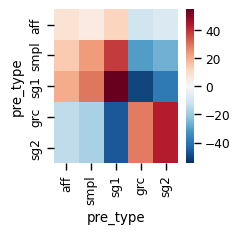

In [68]:

# Define the desired order
order = ['aff', 'smpl', 'sg1', 'grc', 'sg2']

# Reorder rows and columns
df_reordered=cond_input_mat.reindex(index=order, columns=order)

# Ensure the color range is centered around 0
vmin = -max(abs(df_reordered.min().min()), abs(df_reordered.max().max()))
vmax = -vmin

sns.set_context("paper",font_scale=1)
hfig,ax = plt.subplots(1,figsize=(2,2))
sns.heatmap(df_reordered,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0)

plt.savefig('/Users/kperks/Downloads/mg_output_conditional_input_analysis.svg', format='svg', transparent=True)

### an example of shuffle result

<AxesSubplot:xlabel='pre_type', ylabel='pre_type'>

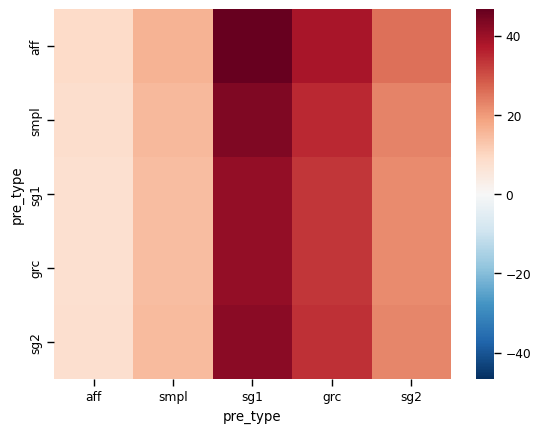

In [408]:

df_syn_shuff = deepcopy(df_syn)
mask = df_syn_shuff['pre_type'].isin(pre_groups) & df_syn_shuff['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
df_syn_shuff = df_syn_shuff[mask]
# Shuffle the dataframe
# df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
shuff_rows = df_syn_shuff[['pre','x','y','z','y_adj','pre_type']].sample(frac = 1)
df_syn_shuff.loc[:,['pre']] = shuff_rows['pre'].values
df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
df_syn_shuff.loc[:,['y_adj']] = shuff_rows['y_adj'].values
df_syn_shuff.loc[:,['pre_type']] = shuff_rows['pre_type'].values

df_edges_shuff=df_syn_shuff.drop(['Unnamed: 0','x','y','z','y_adj','structure'],axis=1).value_counts().reset_index(name='weight')

result_ = np.asarray(get_conditional_input(df_edges_shuff))

cond_input_mat = pd.DataFrame(result_,columns = df_map.columns, index = df_map.columns)

# Define the desired order
order = ['aff', 'smpl', 'sg1', 'grc', 'sg2']

# Reorder rows and columns
df_reordered=cond_input_mat.reindex(index=order, columns=order)

# Ensure the color range is centered around 0
vmin = -max(abs(df_reordered.min().min()), abs(df_reordered.max().max()))
vmax = -vmin

hfig,ax = plt.subplots(1,figsize=(2,2))
sns.heatmap(df_reordered,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0)